In [22]:
import time
import random
from pathlib import Path

import pandas as pd
import numpy
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit import DataStructs
from rdkit.ML.Cluster import Butina
from rdkit.Chem import Draw
from rdkit.Chem import rdFingerprintGenerator
from rdkit.Chem import PandasTools

#from teachopencadd.utils import seed_everything

In [23]:
'''
Clustering can be defined as the task of grouping a set of objects in such a way that objects in the same group (called a cluster) are 
more similar (in some sense) to each other than to those in other groups (clusters).
Compound clustering in pharmaceutical research is often based on chemical or structural similarity between compounds to find groups 
that share properties as well as to design a diverse and representative set for further analysis.
'''

HERE = Path(_dh[-1])
DATA = HERE / "data"

In [24]:
#### Load and have a look into data
#### Filtered data taken from **Edu 02**
compound_df = pd.read_csv(
    DATA / "EGFR_compounds_lipinski.csv",
    index_col=0,
)
print("Dataframe shape:", compound_df.shape)
compound_df.head()

Dataframe shape: (5431, 10)


,molecule_chembl_id,IC50,units,smiles,pIC50,molecular_weight,n_hba,n_hbd,logp,ro5_fulfilled
0,CHEMBL63786,0.003,nM,Brc1cccc(Nc2ncnc3cc4ccccc4cc23)c1,11.522879,349.021459,3,1,5.2891,True
1,CHEMBL35820,0.006,nM,CCOc1cc2ncnc(Nc3cccc(Br)c3)c2cc1OCC,11.221849,387.058239,5,1,4.9333,True
2,CHEMBL53711,0.006,nM,CN(C)c1cc2c(Nc3cccc(Br)c3)ncnc2cn1,11.221849,343.043258,5,1,3.5969,True
3,CHEMBL53753,0.008,nM,CNc1cc2c(Nc3cccc(Br)c3)ncnc2cn1,11.096910,329.027607,5,2,3.5726,True
4,CHEMBL66031,0.008,nM,Brc1cccc(Nc2ncnc3cc4[nH]cnc4cc23)c1,11.096910,339.011957,4,2,4.0122,True


In [25]:
#### Create molecules from SMILES and store in array
compounds = []
# .itertuples() returns a (index, column1, column2, ...) tuple per row
# we don't need index so we use _ instead
# note how we are slicing the dataframe to only the two columns we need now
for _, chembl_id, smiles in compound_df[["molecule_chembl_id", "smiles"]].itertuples():
    compounds.append((Chem.MolFromSmiles(smiles), chembl_id))
compounds[:5]

[(<rdkit.Chem.rdchem.Mol at 0x15f03c0b0>, 'CHEMBL63786'),
 (<rdkit.Chem.rdchem.Mol at 0x15f03c040>, 'CHEMBL35820'),
 (<rdkit.Chem.rdchem.Mol at 0x15f03c190>, 'CHEMBL53711'),
 (<rdkit.Chem.rdchem.Mol at 0x15f03c200>, 'CHEMBL53753'),
 (<rdkit.Chem.rdchem.Mol at 0x15f03c270>, 'CHEMBL66031')]

In [26]:
#### Create fingerprints for all molecules
rdkit_gen = rdFingerprintGenerator.GetRDKitFPGenerator(maxPath=5)
fingerprints = [rdkit_gen.GetFingerprint(mol) for mol, idx in compounds]

# How many compounds/fingerprints do we have?
print("Number of compounds converted:", len(fingerprints))
print("Fingerprint length per compound:", len(fingerprints[0]))

Number of compounds converted: 5431
Fingerprint length per compound: 2048


In [27]:
#### Tanimoto similarity and distance matrix
#### Calculate distance matrix (distance = 1-similarity)

def tanimoto_distance_matrix(fp_list):
    '''Calculate distance matrix for fingerprint list'''
    dissimilarity_matrix = []
    # Notice how we are deliberately skipping the first and last items in the list
    # because we don't need to compare them against themselves
    for i in range(1, len(fp_list)):
        # Compare the current fingerprint against all the previous ones in the list
        similarities = DataStructs.BulkTanimotoSimilarity(fp_list[i], fp_list[:i])
        # Since we need a distance matrix, calculate 1-x for every element in similarity matrix
        dissimilarity_matrix.extend([1 - x for x in similarities])
    return dissimilarity_matrix

In [28]:
#### Side note: That looked like a list and not a matrix.
#### But it is a triangular similarity matrix in the form of a list
n = len(fingerprints)

# Calculate number of elements in triangular matrix via n*(n-1)/2
elem_triangular_matr = (n * (n - 1)) / 2
print(
    f"Elements in the triangular matrix ({elem_triangular_matr:.0f}) ==",
    f"tanimoto_distance_matrix(fingerprints) ({len(tanimoto_distance_matrix(fingerprints))})",
)

Elements in the triangular matrix (14745165) == tanimoto_distance_matrix(fingerprints) (14745165)


In [29]:
####  Clustering molecules: Centroids and exclusion spheres
####  "Butina clustering" (J. Chem. Inf. Model. (1999), 39 (4), 747) was developed to identify smaller but homogeneous clusters, 
####  with the prerequisite that (at least) the cluster centroid will be more similar than a given threshold to every other molecule 
####  in the cluster.

def cluster_fingerprints(fingerprints, cutoff=0.2):
    """Cluster fingerprints
    Parameters:
        fingerprints
        cutoff: threshold for the clustering
    """
    # Calculate Tanimoto distance matrix
    distance_matrix = tanimoto_distance_matrix(fingerprints)
    # Now cluster the data with the implemented Butina algorithm:
    clusters = Butina.ClusterData(distance_matrix, len(fingerprints), cutoff, isDistData=True)
    clusters = sorted(clusters, key=len, reverse=True)
    return clusters

In [30]:
#####  Run the clustering procedure for the dataset
clusters = cluster_fingerprints(fingerprints, cutoff=0.3)

##### Give a short report about the numbers of clusters and their sizes
num_clust_g1 = sum(1 for c in clusters if len(c) == 1)
num_clust_g5 = sum(1 for c in clusters if len(c) > 5)
num_clust_g25 = sum(1 for c in clusters if len(c) > 25)
num_clust_g100 = sum(1 for c in clusters if len(c) > 100)

print("total # clusters: ", len(clusters))
print("# clusters with only 1 compound: ", num_clust_g1)
print("# clusters with >5 compounds: ", num_clust_g5)
print("# clusters with >25 compounds: ", num_clust_g25)
print("# clusters with >100 compounds: ", num_clust_g100)

total # clusters:  919
# clusters with only 1 compound:  445
# clusters with >5 compounds:  197
# clusters with >25 compounds:  34
# clusters with >100 compounds:  4


Number of clusters: 1413 from 5431 molecules at distance cut-off 0.20
Number of molecules in largest cluster: 146
Similarity between two random points in same cluster: 0.82
Similarity between two random points in different cluster: 0.22


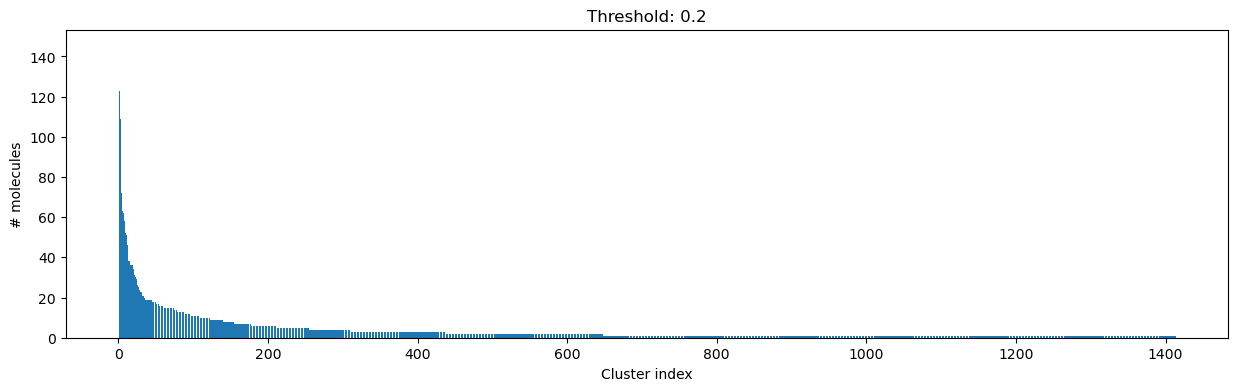

In [31]:
cutoff = 0.2
clusters = cluster_fingerprints(fingerprints, cutoff=cutoff)

# Plot the size of the clusters - save plot
fig, ax = plt.subplots(figsize=(15, 4))
ax.set_xlabel("Cluster index")
ax.set_ylabel("# molecules")
ax.bar(range(1, len(clusters) + 1), [len(c) for c in clusters])
ax.set_title(f"Threshold: {cutoff:3.1f}")
fig.savefig(
    DATA / f"cluster_dist_cutoff_{cutoff:4.2f}.png",
    dpi=300,
    bbox_inches="tight",
    transparent=True,
)

print(
    f"Number of clusters: {len(clusters)} from {len(compounds)} molecules at distance cut-off {cutoff:.2f}"
)
print("Number of molecules in largest cluster:", len(clusters[0]))
print(
    f"Similarity between two random points in same cluster: {DataStructs.TanimotoSimilarity(fingerprints[clusters[0][0]], fingerprints[clusters[0][1]]):.2f}"
)
print(
    f"Similarity between two random points in different cluster: {DataStructs.TanimotoSimilarity(fingerprints[clusters[0][0]], fingerprints[clusters[1][0]]):.2f}"
)

Ten molecules from largest cluster:


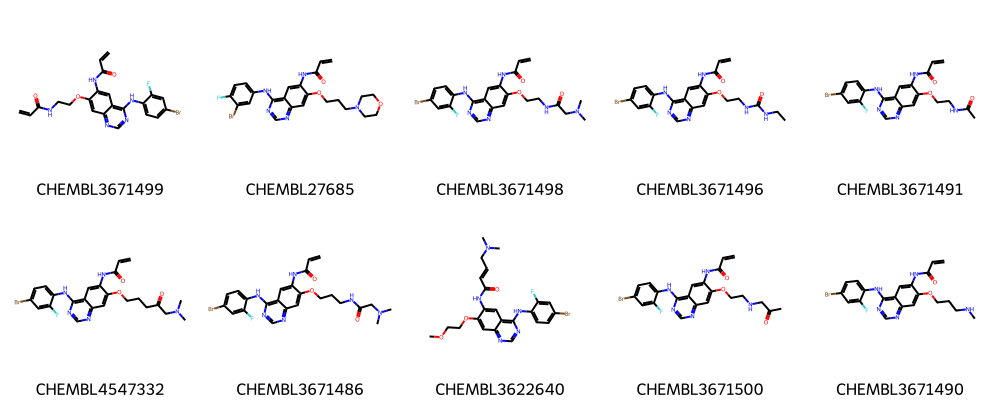

In [32]:
####  10 examples from largest cluster

print("Ten molecules from largest cluster:")
# Draw molecules
Draw.MolsToGridImage(
    [compounds[i][0] for i in clusters[0][:10]],
    legends=[compounds[i][1] for i in clusters[0][:10]],
    molsPerRow=5,
)

In [33]:
####  Save molecules from largest cluster
sdf_path = str(DATA / "molecule_set_largest_cluster.sdf")
sdf = Chem.SDWriter(sdf_path)
for index in clusters[0]:
    mol, label = compounds[index]
    # Add label to metadata
    mol.SetProp("_Name", label)
    sdf.write(mol)
sdf.close()

In [34]:
####  Save molecules from largest cluster 
sdf_path = str(DATA / "EGFR_compounds_lipinski.sdf")
sdf = Chem.SDWriter(sdf_path)
for index in clusters[0]:
    mol, label = compounds[index]
    # Add label to metadata
    mol.SetProp("_Name", label)
    sdf.write(mol)
sdf.close()

Ten molecules from second largest cluster:


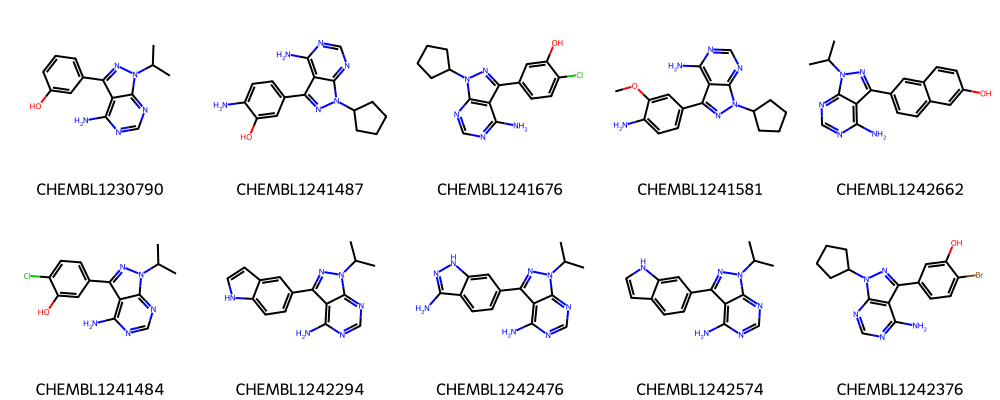

In [35]:
####  Save molecules from second largest cluster
print("Ten molecules from second largest cluster:")
# Draw molecules
Draw.MolsToGridImage(
    [compounds[i][0] for i in clusters[1][:10]],
    legends=[compounds[i][1] for i in clusters[1][:10]],
    molsPerRow=5,
)

Ten molecules from first 10 clusters:


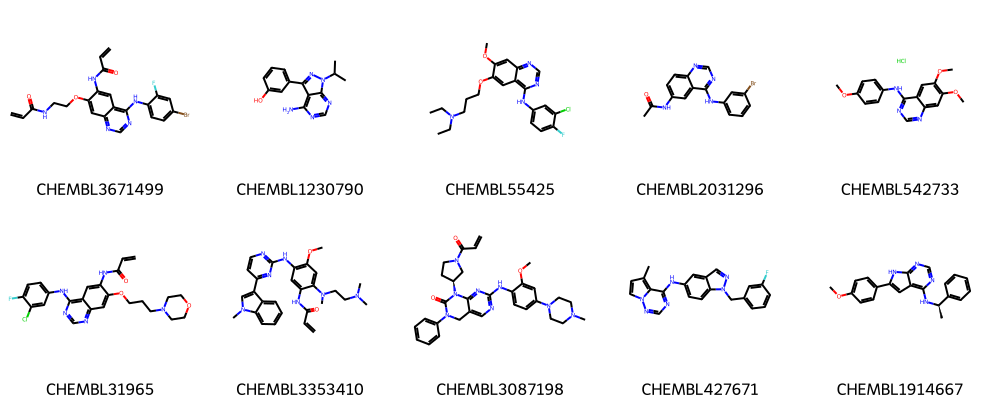

In [36]:
####  Examples from first 10 clusters
print("Ten molecules from first 10 clusters:")
# Draw molecules
Draw.MolsToGridImage(
    [compounds[clusters[i][0]][0] for i in range(10)],
    legends=[compounds[clusters[i][0]][1] for i in range(10)],
    molsPerRow=5,
)

In [37]:
# Generate image
img = Draw.MolsToGridImage(
    [compounds[clusters[i][0]][0] for i in range(0, 3)],
    legends=[f"Cluster {i}" for i in range(1, 4)],
    subImgSize=(200, 200),
    useSVG=True,
)

# Patch RAW svg data: convert non-transparent to transparent background and set font size
molsvg = img.data.replace("opacity:1.0", "opacity:0.0").replace("12px", "20px")

# Save altered SVG data to file
with open(DATA / "cluster_representatives.svg", "w") as f:
    f.write(molsvg)

In [38]:
####  In the following, we are going to pick a final list of max. 1000 compounds as a diverse subset.
####  Aim of this compound picking is to ensure the diversity for a smaller set of compounds which are proposed for testing 
####  in a confirmatory assay.
####  Get the cluster center of each cluster (first molecule in each cluster)
cluster_centers = [compounds[c[0]] for c in clusters]
# How many cluster centers/clusters do we have?
print("Number of cluster centers:", len(cluster_centers))

Number of cluster centers: 1413


In [39]:
#####  Sort the molecules within a cluster based on their similarity
#####  to the cluster center and sort the clusters based on their size
sorted_clusters = []
for cluster in clusters:
    if len(cluster) <= 1:
        continue  # Singletons
    # else:
    # Compute fingerprints for each cluster element
    sorted_fingerprints = [rdkit_gen.GetFingerprint(compounds[i][0]) for i in cluster]
    # Similarity of all cluster members to the cluster center
    similarities = DataStructs.BulkTanimotoSimilarity(
        sorted_fingerprints[0], sorted_fingerprints[1:]
    )
    # Add index of the molecule to its similarity (centroid excluded!)
    similarities = list(zip(similarities, cluster[1:]))
    # Sort in descending order by similarity
    similarities.sort(reverse=True)
    # Save cluster size and index of molecules in clusters_sort
    sorted_clusters.append((len(similarities), [i for _, i in similarities]))
    # Sort in descending order by cluster size
    sorted_clusters.sort(reverse=True)

In [40]:
# Count selected molecules, pick cluster centers first
selected_molecules = cluster_centers.copy()
# Take 10 molecules (or a maximum of 50%) of each cluster starting with the largest one
index = 0
pending = 1000 - len(selected_molecules)
while pending > 0 and index < len(sorted_clusters):
    # Take indices of sorted clusters
    tmp_cluster = sorted_clusters[index][1]
    # If the first cluster is > 10 big then take exactly 10 compounds
    if sorted_clusters[index][0] > 10:
        num_compounds = 10
    # If smaller, take half of the molecules
    else:
        num_compounds = int(0.5 * len(tmp_cluster)) + 1
    if num_compounds > pending:
        num_compounds = pending
    # Write picked molecules and their structures into list of lists called picked_fps
    selected_molecules += [compounds[i] for i in tmp_cluster[:num_compounds]]
    index += 1
    pending = 1000 - len(selected_molecules)
print("# Selected molecules:", len(selected_molecules))

# Selected molecules: 1413


In [41]:
#### Final result
#PandasTools.RenderImagesInAllDataFrames(True)
selected_molecules

[(<rdkit.Chem.rdchem.Mol at 0x15f0653f0>, 'CHEMBL3671499'),
 (<rdkit.Chem.rdchem.Mol at 0x15f30fa00>, 'CHEMBL1230790'),
 (<rdkit.Chem.rdchem.Mol at 0x15f0ac190>, 'CHEMBL55425'),
 (<rdkit.Chem.rdchem.Mol at 0x15f049690>, 'CHEMBL2031296'),
 (<rdkit.Chem.rdchem.Mol at 0x15f2e1310>, 'CHEMBL542733'),
 (<rdkit.Chem.rdchem.Mol at 0x15f0b2260>, 'CHEMBL31965'),
 (<rdkit.Chem.rdchem.Mol at 0x160286c00>, 'CHEMBL3353410'),
 (<rdkit.Chem.rdchem.Mol at 0x15f083060>, 'CHEMBL3087198'),
 (<rdkit.Chem.rdchem.Mol at 0x15f0b8120>, 'CHEMBL427671'),
 (<rdkit.Chem.rdchem.Mol at 0x15f064ac0>, 'CHEMBL1914667'),
 (<rdkit.Chem.rdchem.Mol at 0x15f05b290>, 'CHEMBL4072299'),
 (<rdkit.Chem.rdchem.Mol at 0x15f0c6570>, 'CHEMBL3263380'),
 (<rdkit.Chem.rdchem.Mol at 0x15f3292a0>, 'CHEMBL3416590'),
 (<rdkit.Chem.rdchem.Mol at 0x15f0b1070>, 'CHEMBL207246'),
 (<rdkit.Chem.rdchem.Mol at 0x15f067300>, 'CHEMBL3699587'),
 (<rdkit.Chem.rdchem.Mol at 0x15f03c0b0>, 'CHEMBL63786'),
 (<rdkit.Chem.rdchem.Mol at 0x1602561f0>, 'CHEMBL